In [1]:
# -*- coding: utf-8 -*-
"""
Created on Wed Sep 15 17:28:25 2021

@author: barraly
"""

import csv
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['mathtext.default'] = 'regular'
import matplotlib.cm as cm
import matplotlib.colors as clrs
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Polygon
import pandas as pd
from numpy import pi
import pylab
import scipy.spatial
import matplotlib.patheffects as pe
from matplotlib.cm import ScalarMappable

# Prepare the color map 
cmap = cm.get_cmap('RdYlBu_r', 500)

# The cmap is an array with the colors
cmin = -50
cmax = 320
color_min = cmap(0)
color_max = cmap(500)
pos_0 = -cmin/(cmax-cmin)
color_0 = cmap(0.5)
cmap = clrs.LinearSegmentedColormap.from_list('custom diverging', 
                                             [(0,    color_min),
                                              (pos_0, color_0),
                                              (1,    color_max)], N=500)

newcolors = cmap(np.linspace(0, 1, 500))
index_0 = int(-cmin / (cmax-cmin) * 500)
newcolors[index_0 - 1 : index_0 + 1] = [1, 1, 1, 1]
newcmp = clrs.ListedColormap(newcolors)

/var/folders/mm/v3pbmw2545s_1t9lbf180j1h0000gp/T/ipykernel_12352/1126484541.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('RdYlBu_r', 500)


# Load the dataframes for DAPD with mean measured and nominal concentrations

In [2]:
# Parse the data into dataframes with the average DAPD, using the mean measured concentration to place points on the 2D map
# when availble. The nominal concentrations are used otherwise

# Load the data from the CSVs
CiPA_avg = pd.read_csv('../Experimental data/Data for benchmark - CiPA.csv')
Pharm_avg = pd.read_csv('../Experimental data/Data for benchmark - Pharm.csv')

In [3]:
# Parse the data into dataframes with the average DAPD, using the mean measured concentration to place points on the 2D map
# when availble. The nominal concentrations are used otherwise

# Load the data from CSVs
CiPA_avg_nominal = pd.read_csv('../Experimental data/Data for benchmark - all nominal - CiPA.csv', sep = ';')
Pharm_avg_nominal = pd.read_csv('../Experimental data/Data for benchmark - all nominal - Pharm.csv', sep = ';')

In [5]:
IC50s = pd.read_csv('../Experimental data/Final IC50 dataset.csv', delimiter= ';')

def parse_rescaling(drug, concentration, CiPA_hERG, CiPA_CaV):
    IC50s_filtered = IC50s[IC50s['Drug'] == drug]

    if CiPA_hERG:
        #print('hERG IC50 : ' + str(np.array(IC50s_filtered['hERG IC50 CiPA'])) + ' / ' + str(np.array(IC50s_filtered['hERG h CiPA'])))
        hERG_IC50 = np.array(IC50s_filtered['hERG IC50 CiPA'])
        hERG_h = np.array(IC50s_filtered['hERG h CiPA'])
    else:
        #print('hERG IC50 : ' + str(np.array(IC50s_filtered['hERG IC50 Pharm'])) + ' / ' + str(np.array(IC50s_filtered['hERG h Pharm'])))
        hERG_IC50 = np.array(IC50s_filtered['hERG IC50 Pharm'])
        hERG_h = np.array(IC50s_filtered['hERG h Pharm'])

    if CiPA_CaV:
        #print('CaV IC50 : ' + str(np.array(IC50s_filtered['CaV IC50 CiPA'])) + ' / ' + str(np.array(IC50s_filtered['CaV h CiPA'])))
        CaV_IC50 = np.array(IC50s_filtered['CaV IC50 CiPA'])
        CaV_h = np.array(IC50s_filtered['CaV h CiPA'])
    else:
        #print('CaV IC50 : ' + str(np.array(IC50s_filtered['CaV IC50 Pharm'])) + ' / ' + str(np.array(IC50s_filtered['CaV h Pharm'])))
        CaV_IC50 = np.array(IC50s_filtered['CaV IC50 Pharm'])
        CaV_h = np.array(IC50s_filtered['CaV h Pharm'])

    #print('hERG IC50 : ' + str(hERG_IC50) + ' / ' + str(hERG_h))
    #print('CaV IC50 : ' + str(CaV_IC50) + ' / ' + str(CaV_h))
    
    """
    # Report experimental conditions
    drug_rescale = np.zeros((2, len(concentrations)))
    for d in range(len(concentrations)):
        drug_rescale[0, d] = 1 / (1 + np.power(concentrations[d] / hERG_IC50, hERG_h)) # hERG
        drug_rescale[1, d] = 1 / (1 + np.power(concentrations[d] / CaV_IC50, CaV_h)) # CaV
    """ 

    # Compute current block
    ikr_block = 1 - 1 / (1 + np.power(concentration / hERG_IC50, hERG_h))
    ical_block = 1 - 1 / (1 + np.power(concentration / CaV_IC50, CaV_h))

    return ikr_block, ical_block

In [6]:
# In[Load the data]
data_CiPA = '../Experimental data/All data - exact concentrations and nominal - CiPA.csv'
loaded_CiPA = pd.read_csv(data_CiPA, delimiter = ';')

data_Pharm = '../Experimental data/All data - exact concentrations and nominal - Pharm.csv'
loaded_Pharm = pd.read_csv(data_Pharm, delimiter = ';')

In [7]:
# Add a column to label whether the concentrations were measured or used as nominal
def parse_exact(loaded, CiPA_hERG, CiPA_CaV):
    use_exact = []

    # Loop on all the lines
    for l in range(len(loaded)):
        df = loaded.iloc[l, :]
        # Check if use exact concentrations
        if df['Concentration'] == df['Nominal concentration']:
            use_exact.append(False)
        else:
            use_exact.append(True)

    # Apply a factor to bring the IKr and ICaL rescale to the range 0-1
    loaded['IKr block'] = 0.01 * np.array(loaded['IKr block'])
    loaded['ICaL block'] = 0.01 * np.array(loaded['ICaL block'])
            
    # Build the average DataFrame
    loaded['Use exact'] = np.array(use_exact)
    return loaded

CiPA_exact = parse_exact(loaded_CiPA, True, True)
Pharm_exact = parse_exact(loaded_Pharm, False, False)

# Fitting a quadratic surface through the points with measured concentrations when available

In [10]:
import scipy.optimize
def surface(x, y, theta):
    return theta[0] * x**2  + theta[1] * y**2 + theta[2]*x*y + theta[3]*x + theta[4]*y + theta[5] * x**3 + theta[6] * y**3 + theta[7]*(x**2)*y + theta[8]*(y**2)*x 
    

In [11]:
# Find the optimal quadratic surface that matches the data
def constraints_verified(theta):
    # Force a monotonous surface
    x = np.linspace(0, 100, 101)
    y = np.linspace(0, 100, 101)
    surface_sim = np.transpose(surface(x[:, None], y, theta))
    
    # Check the corners
    if surface_sim[0, -1] < 200 or surface_sim[-1, 0] > -50:
        return False
    
    # Compute the derivate for each point
    dfdx = surface_sim[:, 1:] - surface_sim[:, :-1]
    dfdy = surface_sim[1:, :] - surface_sim[:-1, :]
    
    if np.any(dfdx < 0) or np.any(dfdy > 0):
        return False
    
    return True

def surface_score(theta, *loaded): 
    loaded = loaded[0]
    # Get the coordinates of points
    xs = np.array(loaded['IKr block']) * 100
    ys = np.array(loaded['ICaL block']) * 100
    
    
    # Initialise the output
    scores = np.zeros(len(xs))
    
    # Compute the score
    scores = (surface(xs, ys, theta) - np.array(loaded['DAPD']))
    
    # Check the constraints
    if not constraints_verified(theta):
        scores *= 100
    return np.sum(np.power(abs(scores), 2))


theta_0 = [ 3.31901936e-03,  1.83675832e-02, -1.50052955e-02,  3.04923773e-01, -4.39749512e-01,  1.43191411e-04, -2.78594673e-04, -3.23744663e-04, 3.98002371e-04]
print('Initial guess : ' + str(theta_0))

res = scipy.optimize.differential_evolution(surface_score, bounds = ([(-5, 5) for _ in range(9)]),
                                            x0=theta_0, args=(CiPA_exact, ))
theta_CiPA = res.x
print('Optimal theta: ' + str(theta_CiPA))
print('Score for optimal surface: ' + str(res.fun))
print('Constraints are verified for CiPA map: ' + str(constraints_verified(theta_CiPA)))

res = scipy.optimize.differential_evolution(surface_score, bounds = ([(-5, 5) for _ in range(9)]),
                                            x0=theta_0, args=(Pharm_exact, ))
theta_Pharm = res.x
print('\nOptimal theta: ' + str(theta_Pharm))
print('Score for optimal surface: ' + str(res.fun))
print('Constraints are verified for Pharm map: ' + str(constraints_verified(theta_Pharm)))

# Deduce the surface fitted through individual points
x = np.linspace(0, 100, 101)
y = np.linspace(0, 100, 101)
surface_CiPA_exact = np.transpose(surface(x[:, None], y, theta_CiPA))
surface_Pharm_exact = np.transpose(surface(x[:, None], y, theta_Pharm))

#x = np.linspace(0, 100, 101)
#y = np.linspace(0, 100, 101)
#surface_sim = surface(x[:, None], y, theta_0)
#print(np.shape(surface_sim))
#print(surface_sim[100, 0])

Initial guess : [0.00331901936, 0.0183675832, -0.0150052955, 0.304923773, -0.439749512, 0.000143191411, -0.000278594673, -0.000323744663, 0.000398002371]
Optimal theta: [-1.21035729e-02  8.10290545e-02 -6.73442573e-02  1.97832289e+00
 -2.27882742e+00  3.25082778e-04 -9.60143388e-04 -4.82422719e-04
  1.11135306e-03]
Score for optimal surface: 342112.9253840132
Constraints are verified for CiPA map: True

Optimal theta: [ 1.64666572e-02  5.60311667e-02 -6.37476406e-02  9.07273782e-01
 -1.54469129e+00  1.46821212e-04 -6.83524551e-04 -6.32864621e-04
  1.14731788e-03]
Score for optimal surface: 358188.6782469771
Constraints are verified for Pharm map: True


In [12]:
# Fit the quadratic surface through the points placed with mean measured concentrations (when available)
print('Initial guess : ' + str(theta_0))

res = scipy.optimize.differential_evolution(surface_score, bounds = ([(-5, 5) for _ in range(9)]),
                                            x0=theta_0, args=(CiPA_avg, ))
theta_CiPA_avg = res.x
print('Optimal theta: ' + str(theta_CiPA))
print('Score for optimal surface: ' + str(res.fun))
print('Constraints are verified for CiPA map: ' + str(constraints_verified(theta_CiPA)))

res = scipy.optimize.differential_evolution(surface_score, bounds = ([(-5, 5) for _ in range(9)]),
                                            x0=theta_0, args=(Pharm_avg, ))
theta_Pharm_avg = res.x
print('\nOptimal theta: ' + str(theta_Pharm))
print('Score for optimal surface: ' + str(res.fun))
print('Constraints are verified for Pharm map: ' + str(constraints_verified(theta_Pharm)))

x = np.linspace(0, 100, 101)
y = np.linspace(0, 100, 101)
surface_CiPA_avg = np.transpose(surface(x[:, None], y, theta_CiPA_avg))
surface_Pharm_avg = np.transpose(surface(x[:, None], y, theta_Pharm_avg))

Initial guess : [0.00331901936, 0.0183675832, -0.0150052955, 0.304923773, -0.439749512, 0.000143191411, -0.000278594673, -0.000323744663, 0.000398002371]
Optimal theta: [-1.21035729e-02  8.10290545e-02 -6.73442573e-02  1.97832289e+00
 -2.27882742e+00  3.25082778e-04 -9.60143388e-04 -4.82422719e-04
  1.11135306e-03]
Score for optimal surface: 10264.447090355736
Constraints are verified for CiPA map: True

Optimal theta: [ 1.64666572e-02  5.60311667e-02 -6.37476406e-02  9.07273782e-01
 -1.54469129e+00  1.46821212e-04 -6.83524551e-04 -6.32864621e-04
  1.14731788e-03]
Score for optimal surface: 17152.109834572275
Constraints are verified for Pharm map: True


In [13]:
# Fit the quadratic surface through the points placed with nominal concentrations
print('Initial guess : ' + str(theta_0))

res = scipy.optimize.differential_evolution(surface_score, bounds = ([(-5, 5) for _ in range(9)]),
                                            x0=theta_0, args=(CiPA_avg_nominal, ))
theta_CiPA_nominal = res.x
print('Optimal theta: ' + str(theta_CiPA))
print('Score for optimal surface: ' + str(res.fun))
print('Constraints are verified for CiPA map: ' + str(constraints_verified(theta_CiPA)))

res = scipy.optimize.differential_evolution(surface_score, bounds = ([(-5, 5) for _ in range(9)]),
                                            x0=theta_0, args=(Pharm_avg_nominal, ))
theta_Pharm_nominal = res.x
print('\nOptimal theta: ' + str(theta_Pharm))
print('Score for optimal surface: ' + str(res.fun))
print('Constraints are verified for Pharm map: ' + str(constraints_verified(theta_Pharm)))

x = np.linspace(0, 100, 101)
y = np.linspace(0, 100, 101)
surface_CiPA_nominal = np.transpose(surface(x[:, None], y, theta_CiPA_nominal))
surface_Pharm_nominal = np.transpose(surface(x[:, None], y, theta_Pharm_nominal))

Initial guess : [0.00331901936, 0.0183675832, -0.0150052955, 0.304923773, -0.439749512, 0.000143191411, -0.000278594673, -0.000323744663, 0.000398002371]
Optimal theta: [-1.21035729e-02  8.10290545e-02 -6.73442573e-02  1.97832289e+00
 -2.27882742e+00  3.25082778e-04 -9.60143388e-04 -4.82422719e-04
  1.11135306e-03]
Score for optimal surface: 10986.614677720068
Constraints are verified for CiPA map: True

Optimal theta: [ 1.64666572e-02  5.60311667e-02 -6.37476406e-02  9.07273782e-01
 -1.54469129e+00  1.46821212e-04 -6.83524551e-04 -6.32864621e-04
  1.14731788e-03]
Score for optimal surface: 13114.157739866361
Constraints are verified for Pharm map: True


# Plot the 2-D map of experimental data, using the surface fitted through individual points and the placing the points reporting man measured concentrations

<>:37: SyntaxWarning: invalid escape sequence '\m'
<>:38: SyntaxWarning: invalid escape sequence '\m'
<>:85: SyntaxWarning: invalid escape sequence '\l'
<>:85: SyntaxWarning: invalid escape sequence '\g'
<>:114: SyntaxWarning: invalid escape sequence '\g'
<>:115: SyntaxWarning: invalid escape sequence '\D'
<>:37: SyntaxWarning: invalid escape sequence '\m'
<>:38: SyntaxWarning: invalid escape sequence '\m'
<>:85: SyntaxWarning: invalid escape sequence '\l'
<>:85: SyntaxWarning: invalid escape sequence '\g'
<>:114: SyntaxWarning: invalid escape sequence '\g'
<>:115: SyntaxWarning: invalid escape sequence '\D'
/var/folders/mm/v3pbmw2545s_1t9lbf180j1h0000gp/T/ipykernel_12352/1180483738.py:37: SyntaxWarning: invalid escape sequence '\m'
  ax.set_xlabel('$\mathregular{I_{Kr}}$ inhibition', fontsize = labelsize)
/var/folders/mm/v3pbmw2545s_1t9lbf180j1h0000gp/T/ipykernel_12352/1180483738.py:38: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel('$\mathregular{I_{CaL}}$ inhibition', f

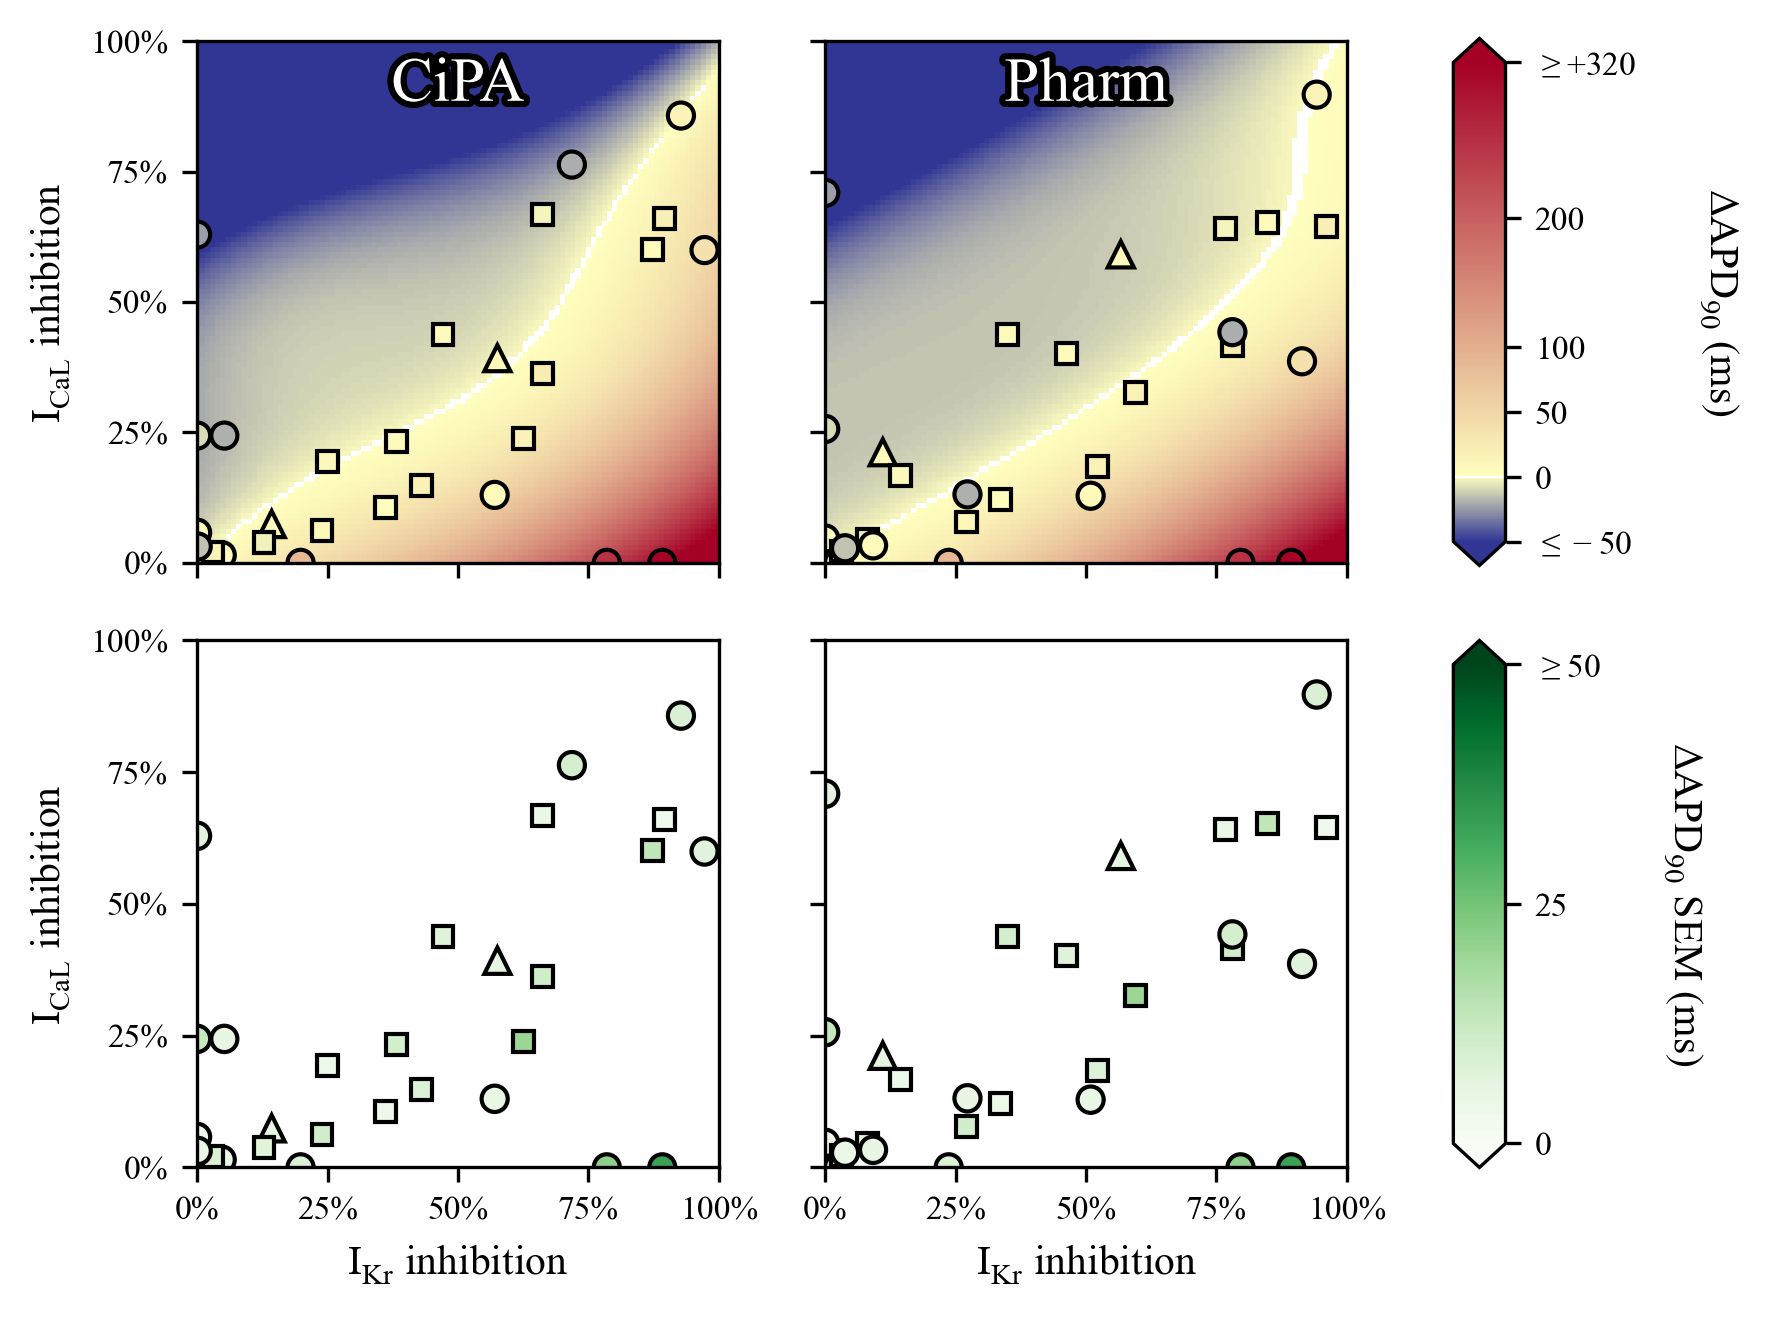

In [14]:
# In[Plot the validation samples]

def plot_map_and_surface(data_avg, surface, cmin = -50, cmax = 320, ax=None, cmap = cmap, plot_sem = False):
    # Define the figure
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize = (6, 6))
        
    # Plot the quadratic surface
    if not plot_sem:
        ax.imshow(surface, origin = 'lower', cmap=cmap, vmin=cmin, vmax=cmax)
    
    # Add the map of exp points
    radius = 5
    for pt in range(len(data_avg)):
        x, y = (100 * (data_avg['IKr block'][pt]), 100 * (data_avg['ICaL block'][pt]))
        if str(data_avg['Use exact'][pt]) == 'Hybrid':
            xy = np.array([[x - 2.5, y - 2.5], [x, y + 2.5], [x + 2.5, y - 2.5]])
            e = patches.Polygon(xy, alpha = 1)
            
        elif str(data_avg['Use exact'][pt]) == 'True':
            e = patches.Rectangle((x, y), 0.8 * radius, 0.8 * radius, alpha = 1)
        elif str(data_avg['Use exact'][pt]) == 'False':
            e = patches.Ellipse((x, y), radius, radius, alpha = 1)

        # Aesthetics
        e.set_edgecolor(color = 'k')
        if plot_sem:
            col = cmap((data_avg['SEM'][pt]-cmin) / (cmax-cmin))
        else:
            col = cmap((data_avg['DAPD'][pt]-cmin) / (cmax-cmin))
        e.set_facecolor(col)
        ax.add_artist(e)
            
    ax.autoscale()
    
    # Axes
    ax.set_xlabel('$\mathregular{I_{Kr}}$ inhibition', fontsize = labelsize)
    ax.set_ylabel('$\mathregular{I_{CaL}}$ inhibition', fontsize = labelsize)
    ax.set_xlim([0, 100])
    ax.set_ylim([0, 100])
    ax.set_xticks([0, 25, 50, 75, 100])
    ax.set_xticklabels(['0%', '25%', '50%', '75%', '100%'])
    ax.set_yticks([0, 25, 50, 75, 100])
    ax.set_yticklabels(['0%', '25%', '50%', '75%', '100%'])
    
    return None

# Desing the figure
mosaic = [['CiPA DAPD', 'Pharm DAPD', 'cbar DAPD'],
          ['CiPA std', 'Pharm std', 'cbar std']]
fig, axes = plt.subplot_mosaic(mosaic, figsize = (6, 4.5), gridspec_kw=dict(width_ratios=[1, 1, 0.1]))
fig.set_dpi(300)
fig.patch.set_facecolor('white')

# Fonts
labelsize = 10
ticksize = 8

# CiPA
ax = axes['CiPA DAPD']
plot_map_and_surface(CiPA_avg, surface_CiPA_exact, ax=ax, cmap = newcmp)
ax.text(x=50, y = 97, s = 'CiPA', fontsize = labelsize+5, color = 'white', ha = 'center', va = 'top', path_effects=[pe.withStroke(linewidth=3, foreground='black')])
ax.set_xticklabels(['', '', '', '', ''])
ax.set_xlabel('')
ax.tick_params(labelsize = ticksize)

# Pharm
ax = axes['Pharm DAPD']
plot_map_and_surface(Pharm_avg, surface_Pharm_exact, ax=ax, cmap = newcmp)
ax.text(x=50, y = 97, s = 'Pharm', fontsize = labelsize+5, color = 'white', ha = 'center', va = 'top', path_effects=[pe.withStroke(linewidth=3, foreground='black')])
ax.set_ylabel('')
ax.set_yticklabels(['', '', '', '', ''])
ax.set_xticklabels(['', '', '', '', ''])
ax.set_xlabel('')

# Add the legend
ax = axes['cbar DAPD']
norm = plt.Normalize(-50, 320)

sm =  ScalarMappable(norm=norm, cmap=newcmp)
sm.set_array([])

cbar = fig.colorbar(sm, extend = 'both', cax = ax)
cbar.set_ticks([-50, 0, 50, 100, 200, 320])
cbar.ax.set_yticklabels(['$\leq -$50', 0, 50, 100, 200, '$\geq$+320'], fontsize = ticksize)
cbar.set_label('$\\mathregular{\\Delta APD_{90}}$ (ms)', rotation=270, fontsize = labelsize, labelpad = 25)


# CiPA std
ax = axes['CiPA std']
ax.tick_params(labelsize = ticksize)
plot_map_and_surface(CiPA_avg, surface_CiPA_exact, ax=ax, cmap = cm.get_cmap('Greens'), cmin = 0 ,cmax = 50, plot_sem = True)
#ax.text(x=50, y = 98, s = 'CiPA', fontsize = 30, color = 'white', ha = 'center', va = 'top',
#       path_effects=[pe.withStroke(linewidth=3, foreground='black')])


# CiPA std
ax = axes['Pharm std']
ax.tick_params(labelsize = ticksize)
plot_map_and_surface(Pharm_avg, surface_Pharm_exact, ax=ax, cmap = cm.get_cmap('Greens'), cmin = 0 ,cmax = 50, plot_sem = True)
#ax.text(x=50, y = 98, s = 'Pharm', fontsize = 30, color = 'white', ha = 'center', va = 'top',
#       path_effects=[pe.withStroke(linewidth=3, foreground='black')])
ax.set_ylabel('')
ax.set_yticklabels(['', '', '', '', ''])

# Add the legend
ax = axes['cbar std']
norm = plt.Normalize(0, 50)
sm =  ScalarMappable(cmap=cm.get_cmap('Greens'), norm = norm)
sm.set_array([])

cbar = fig.colorbar(sm, extend = 'both', cax = ax)
cbar.set_ticks([0, 25, 50])
cbar.ax.set_yticklabels([0, 25, '$\geq$50'], fontsize = ticksize)
cbar.set_label('$\Delta$APD$_{90}$ SEM (ms)', rotation=270, fontsize = labelsize, labelpad = 25)


# Save
save_name = 'DAPD experimental benchmark cubic surface - exact concentrations'
plt.tight_layout()
plt.savefig(save_name + '.png', dpi = 300, transparent=True)
plt.savefig(save_name + '.pdf', format = 'pdf', transparent=True)



# Compare the experimental data with the fitted surface

<>:21: SyntaxWarning: invalid escape sequence '\m'
<>:22: SyntaxWarning: invalid escape sequence '\m'
<>:43: SyntaxWarning: invalid escape sequence '\m'
<>:68: SyntaxWarning: invalid escape sequence '\D'
<>:21: SyntaxWarning: invalid escape sequence '\m'
<>:22: SyntaxWarning: invalid escape sequence '\m'
<>:43: SyntaxWarning: invalid escape sequence '\m'
<>:68: SyntaxWarning: invalid escape sequence '\D'
/var/folders/mm/v3pbmw2545s_1t9lbf180j1h0000gp/T/ipykernel_12352/1802051791.py:21: SyntaxWarning: invalid escape sequence '\m'
  ax.set_xlabel('% $\mathregular{I_{Kr}}$ inhibition', fontsize = labelsize)
/var/folders/mm/v3pbmw2545s_1t9lbf180j1h0000gp/T/ipykernel_12352/1802051791.py:22: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel('% $\mathregular{I_{CaL}}$ inhibition', fontsize = labelsize)
/var/folders/mm/v3pbmw2545s_1t9lbf180j1h0000gp/T/ipykernel_12352/1802051791.py:43: SyntaxWarning: invalid escape sequence '\m'
  ax.set_xlabel('% $\mathregular{I_{Kr}}$ inhibition', f

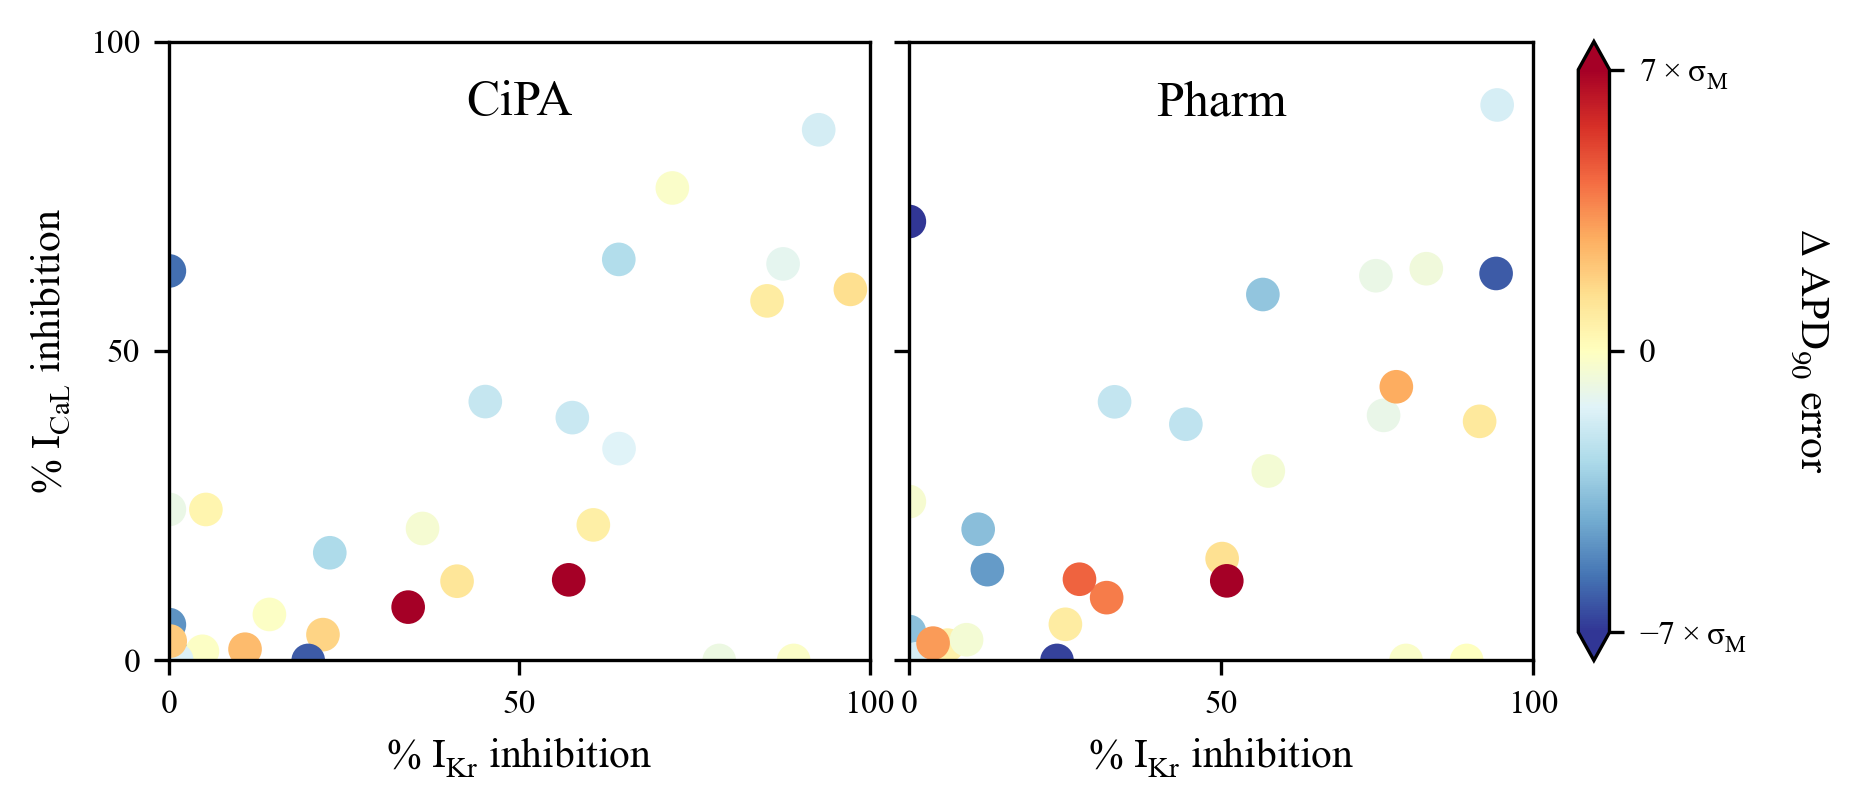

In [15]:
# Plot a map for sruface fits
mosaic = [['CiPA errors', 'Pharm errors']]
fig, axes = plt.subplot_mosaic(mosaic, figsize = (6, 2.5), gridspec_kw=dict(width_ratios=[1, 1]))
fig.set_dpi(300)
fig.patch.set_facecolor('white')

# Fonts
labelsize = 10
ticksize = 8

# Define the colormap
cmap = cm.get_cmap('RdYlBu_r')

# CiPA errors
ax = axes['CiPA errors']
ax.set_ylim(0, 100)
ax.set_xlim(0, 100)
ax.set_xticks([0, 50, 100])
ax.set_yticks([0, 50, 100])
ax.tick_params(labelsize = ticksize)
ax.set_xlabel('% $\mathregular{I_{Kr}}$ inhibition', fontsize = labelsize)
ax.set_ylabel('% $\mathregular{I_{CaL}}$ inhibition', fontsize = labelsize)
ax.text(50, 90, ha = 'center', va = 'center', s = 'CiPA', fontsize = labelsize+2)

# Compute the errors in the fitted quadratic surface
x = 100 * (np.array(CiPA_avg['IKr block']))
y = 100 * (np.array(CiPA_avg['ICaL block']))
surface_CiPA_exp = np.transpose(surface(x, y, theta_CiPA))

# Plot the errors in the fits
c =  (surface_CiPA_exp - np.array(CiPA_avg['DAPD'])) / np.array(CiPA_avg['SEM'])
ax.scatter(x, y, s=50, cmap = cmap, c=c, norm = plt.Normalize(-7, 7))
#print(np.sum(abs(c)))

# Pharm errors
ax = axes['Pharm errors']
ax.set_xticks([0, 50, 100])
ax.set_yticks([0, 50, 100])
ax.set_xlim(0, 100)
ax.set_ylim(0, 100)
ax.tick_params(labelsize = ticksize)
ax.set_yticklabels(['', '', ''])
ax.set_xlabel('% $\mathregular{I_{Kr}}$ inhibition', fontsize = labelsize)
ax.text(50, 90, ha = 'center', va = 'center', s = 'Pharm', fontsize = labelsize+2)

# Compute the errors in the fitted quadratic surface
x = 100 * (np.array(Pharm_avg['IKr block']))
y = 100 * (np.array(Pharm_avg['ICaL block']))
surface_Pharm_exp = np.transpose(surface(x, y, theta_Pharm))


# Plot the errors in the fits
c =  (surface_Pharm_exp - np.array(Pharm_avg['DAPD'])) / np.array(Pharm_avg['SEM'])
ax.scatter(x, y, s=50, cmap = cmap, c=c, norm = plt.Normalize(-7, 7))
#print(np.sum(abs(c)))

# Add the legend
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.15)

norm = clrs.Normalize(vmin=-7, vmax=7)
sm =  ScalarMappable(norm=norm, cmap=cm.get_cmap('RdYlBu_r'))
sm.set_array([])

cbar = fig.colorbar(sm, extend = 'both', cax = cax, ticks = [-7, 0, 7])
cbar.ax.set_yticklabels([r'$-7 \times \sigma_M$', 0, r'$7 \times \sigma_M$'], fontsize = ticksize)
cbar.set_label('$\Delta$ APD$_{90}$ error', rotation=270, fontsize = labelsize, labelpad= 20)

   
# Get no pad between plots
plt.tight_layout(pad = 0)

plt.savefig('Cubic surface goodness of fit.png', dpi = 300)
plt.savefig('Cubic surface goodness of fit.pdf', transparent=True, format = 'pdf', bbox_inches = 'tight')

# Plot the maps of all nominal

<>:35: SyntaxWarning: invalid escape sequence '\m'
<>:36: SyntaxWarning: invalid escape sequence '\m'
<>:106: SyntaxWarning: invalid escape sequence '\l'
<>:106: SyntaxWarning: invalid escape sequence '\g'
<>:107: SyntaxWarning: invalid escape sequence '\D'
<>:35: SyntaxWarning: invalid escape sequence '\m'
<>:36: SyntaxWarning: invalid escape sequence '\m'
<>:106: SyntaxWarning: invalid escape sequence '\l'
<>:106: SyntaxWarning: invalid escape sequence '\g'
<>:107: SyntaxWarning: invalid escape sequence '\D'
/var/folders/mm/v3pbmw2545s_1t9lbf180j1h0000gp/T/ipykernel_12352/2597949019.py:35: SyntaxWarning: invalid escape sequence '\m'
  ax.set_xlabel('% $\mathregular{I_{Kr}}$ inhibition', fontsize = 18)
/var/folders/mm/v3pbmw2545s_1t9lbf180j1h0000gp/T/ipykernel_12352/2597949019.py:36: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel('% $\mathregular{I_{CaL}}$ inhibition', fontsize = 18)
/var/folders/mm/v3pbmw2545s_1t9lbf180j1h0000gp/T/ipykernel_12352/2597949019.py:106: Synta

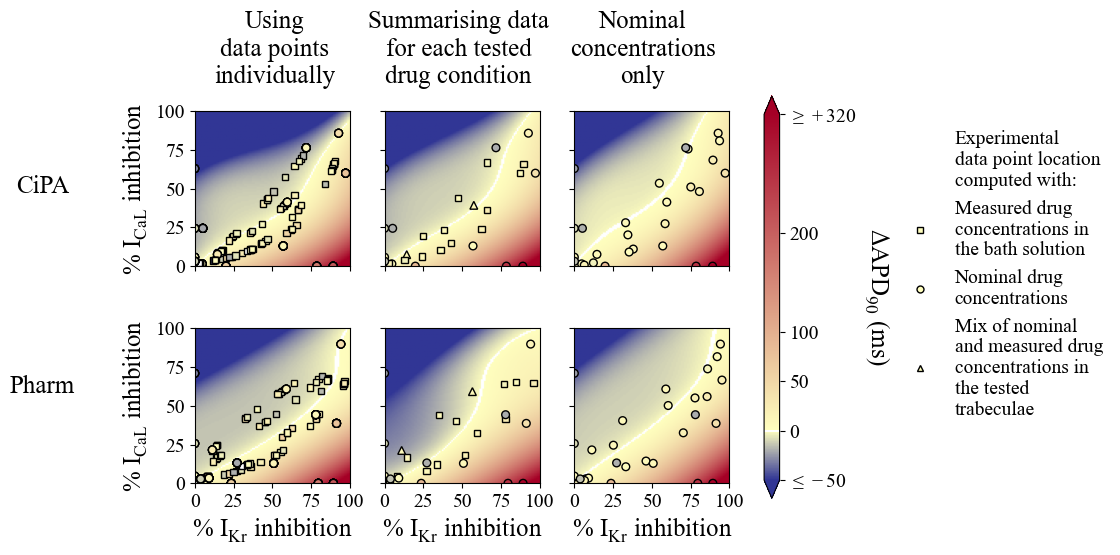

In [16]:
def plot_map_and_surface(data_avg, surface, cmin = -50, cmax = 320, ax=None, cmap = cmap, plot_std = False):
    # Define the figure
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize = (8, 8))
        
    # Plot the quadratic surface
    if not plot_std:
        ax.imshow(surface, origin = 'lower', cmap=cmap, vmin=cmin, vmax=cmax)
    
    # Add the map of exp points
    radius = 5
    for pt in range(len(data_avg)):
        x, y = (100 * (data_avg['IKr block'][pt]), 100 * (data_avg['ICaL block'][pt]))
        if str(data_avg['Use exact'][pt]) == 'Hybrid':
            xy = np.array([[x - 2.5, y - 2.5], [x, y + 2.5], [x + 2.5, y - 2.5]])
            e = patches.Polygon(xy, alpha = 1)
            
        elif str(data_avg['Use exact'][pt]) == 'True':
            e = patches.Rectangle((x, y), 0.8 * radius, 0.8 * radius, alpha = 1)
        elif str(data_avg['Use exact'][pt]) == 'False':
            e = patches.Ellipse((x, y), radius, radius, alpha = 1)

        # Aesthetics
        e.set_edgecolor(color = 'k')
        if plot_std:
            col = cmap((data_avg['STD'][pt]-cmin) / (cmax-cmin))
        else:
            col = cmap((data_avg['DAPD'][pt]-cmin) / (cmax-cmin))
        e.set_facecolor(col)
        ax.add_artist(e)
            
    ax.autoscale()
    
    # Axes
    ax.set_xlabel('% $\mathregular{I_{Kr}}$ inhibition', fontsize = 18)
    ax.set_ylabel('% $\mathregular{I_{CaL}}$ inhibition', fontsize = 18)
    ax.set_xlim([0, 100])
    ax.set_ylim([0, 100])
    ax.set_xticks([0, 25, 50, 75, 100])
    ax.set_yticks([0, 25, 50, 75, 100])
    ax.tick_params(labelsize = 14)
    
    return None

# Desing the figure
mosaic = [['CiPA exact', 'CiPA mix', 'CiPA nom', 'cbar DAPD'],
          ['Pharm exact', 'Pharm mix', 'Pharm nom', 'cbar DAPD']]
fig, axes = plt.subplot_mosaic(mosaic, figsize = (8, 5), gridspec_kw=dict(width_ratios=[1, 1, 1, 0.1]))
fig.patch.set_facecolor('white')


# CiPA
ax = axes['CiPA exact']
plot_map_and_surface(CiPA_exact, surface_CiPA_exact, ax=ax, cmap = newcmp)
ax.set_xticklabels(['', '', '', '', ''])
ax.set_xlabel('')

# Pharm
ax = axes['Pharm exact']
plot_map_and_surface(Pharm_exact, surface_Pharm_exact, ax=ax, cmap = newcmp)


# CiPA using the mean concentration computed from 
ax = axes['CiPA mix']
plot_map_and_surface(CiPA_avg, surface_CiPA_avg, ax=ax, cmap = newcmp)
# Set the axes
ax.set_xlabel('')
ax.set_xticklabels(['', '', '', '', ''])
ax.set_ylabel('')
ax.set_yticklabels(['', '', '', '', ''])

# Pharm
ax = axes['Pharm mix']
plot_map_and_surface(Pharm_avg, surface_Pharm_avg, ax=ax, cmap = newcmp)
ax.set_ylabel('')
ax.set_yticklabels(['', '', '', '', ''])

# CiPA nominal concentrations
ax = axes['CiPA nom']
plot_map_and_surface(CiPA_avg_nominal, surface_CiPA_nominal, ax=ax, cmap = newcmp)
#ax.text(x=50, y = 98, s = 'CiPA', fontsize = 30, color = 'white', ha = 'center', va = 'top',
#       path_effects=[pe.withStroke(linewidth=3, foreground='black')])
# Set the axes
ax.set_xlabel('')
ax.set_xticklabels(['', '', '', '', ''])
ax.set_ylabel('')
ax.set_yticklabels(['', '', '', '', ''])

# Pharm nominal concentrations
ax = axes['Pharm nom']
plot_map_and_surface(Pharm_avg_nominal, surface_Pharm_nominal, ax=ax, cmap = newcmp)
#ax.text(x=50, y = 98, s = 'Pharm', fontsize = 30, color = 'white', ha = 'center', va = 'top',
#       path_effects=[pe.withStroke(linewidth=3, foreground='black')])
ax.set_ylabel('')
ax.set_yticklabels(['', '', '', '', ''])

# Add the legend
ax = axes['cbar DAPD']
norm = plt.Normalize(-50, 320)

sm =  ScalarMappable(norm=norm, cmap=newcmp)
sm.set_array([])

cbar = fig.colorbar(sm, extend = 'both', cax = ax)
cbar.set_ticks([-50, 0, 50, 100, 200, 320])
cbar.ax.set_yticklabels(['$\leq -$50', 0, 50, 100, 200, '$\geq +320$'], fontsize = 14)
cbar.set_label('$\Delta$APD$_{90}$ (ms)', rotation=270, fontsize = 18, labelpad = 25)

# Add a legend
import matplotlib.lines as lines
custom_lines = [lines.Line2D([], [], color = 'w'),
                lines.Line2D([], [], color = 'w', marker = 's', markeredgecolor = 'k', markersize = 5, markerfacecolor = cmap(0.5)),
                lines.Line2D([], [], color = 'w', marker = 'o', markeredgecolor = 'k', markersize = 5, markerfacecolor = cmap(0.5)),
                lines.Line2D([], [], color = 'w', marker = '^', markeredgecolor = 'k', markersize = 5, markerfacecolor = cmap(0.5)),]

labels = ['Experimental\ndata point location\ncomputed with:',
          'Measured drug\nconcentrations in\nthe bath solution',
          'Nominal drug\nconcentrations',
          'Mix of nominal\nand measured drug\nconcentrations in\nthe tested\ntrabeculae',]

plt.figlegend(custom_lines, labels, bbox_to_anchor=(0.97, 0.45, 0.2, 0.3), 
              edgecolor = 'w', loc='center left', fontsize = 14)


# Label
fig.text(x=-0.08, y = 0.8, s = 'CiPA', fontsize = 18, color = 'k', ha = 'center', va = 'top')
fig.text(x=-0.08, y = 0.4, s = 'Pharm', fontsize = 18, color = 'k', ha = 'center', va = 'top')
fig.text(x = 0.21, y = 1.05, s = 'Using\ndata points\nindividually', fontsize = 18, ha = 'center', va = 'center')
fig.text(x = 0.44, y = 1.05, s = 'Summarising data\nfor each tested\ndrug condition', fontsize = 18, ha = 'center', va = 'center')
fig.text(x = 0.67, y = 1.05, s = 'Nominal\nconcentrations\nonly', fontsize = 18, ha = 'center', va = 'center')

# Save
save_name = 'DAPD experimental benchmark cubic surface - nominal vs exact concentrations'
plt.tight_layout()
plt.savefig(save_name + '.png', dpi = 300, transparent=True, bbox_inches = 'tight')
plt.savefig(save_name + '.pdf', format = 'pdf', transparent=True, bbox_inches = 'tight')
